In [3]:
%load_ext autoreload
%autoreload 2  

import numpy as np
import pandas as pd
import yfinance as yf
# from pandas_datareader import data as pdr
import functions as f
import matplotlib.pyplot as plt
import datetime as dt
import functions as f

from pypfopt.efficient_frontier import EfficientFrontier
# from pypfopt import risk_models
# from pypfopt import expected_returns
from pypfopt import HRPOpt

In [54]:
acoes = f.tickers(['petr4', 'vale3', 'bbdc4', 'itub4', 'cmig3', 'cple6', 'ggbr4','wege3','abev3','usim5', 'trpl4'])
# acoes = f.tickers('tickers.txt')l
stock_prices = f.download_portfolio(acoes, start='2010-01-01' , end='2022-12-31' , fill=False, drop=True)
rets = f.returns(stock_prices); rets.shape

[*********************100%***********************]  11 of 11 completed


(155, 11)

In [55]:
periodos = 24 
oot = 4

def portfolio_pipeline(periodos: int, oot: int):
    retornos = []

    for i, month in enumerate(stock_prices.index):
        if stock_prices[(i+periodos) : (i+periodos+oot)].shape[0] > oot-1:
            train_df = stock_prices[(i) : (i+periodos)]
            oot_df = stock_prices[(i+periodos) : (i+periodos+oot)].pct_change(oot-1).dropna() ## to pulando 1 mes pra não rolar DATA LEAKAGE
            
            hrp = HRPOpt(train_df)
            hrp.optimize()
            pesos_hrp = np.array(list(hrp.clean_weights().values()))
            pesos_df = pd.DataFrame(data={'pesos':pesos_hrp}, index=oot_df.columns).sort_values(by='pesos', ascending=False).T
            
            stock_rets = []
            for n, date in enumerate(oot_df.index):
                for stock in oot_df.columns:
                    retorno_mes = oot_df[stock][n] * pesos_df[stock][n]
                    stock_rets.append(retorno_mes)
                retornos.append(retorno_mes)

            
            print(f'Periodo de Treino: {train_df.index.min()} até {train_df.index.max()}\n\
    Periodo de Validação {oot_df.index} \n {pesos_df*100} \n ----- \n') ## ULTIMO MÊS NÂO VAI TER PERIODO DE VALIDAÇÃO, POR QUE É O MÊS "ATUAL" 
        
        else:
            # print(stock_prices[(i+periodos) : (i+periodos+oot)].shape[0])
            # print(stock_prices[(i+periodos) : (i+periodos+oot)].shape[0])
            break
        
    return retornos
    
retornos = portfolio_pipeline(periodos, oot)

Periodo de Treino: 2010-01-01 00:00:00 até 2011-12-01 00:00:00
    Periodo de Validação DatetimeIndex(['2012-04-01'], dtype='datetime64[ns]', name='Date', freq=None) 
        CPLE6.SA  WEGE3.SA  BBDC4.SA  TRPL4.SA  CMIG3.SA  ITUB4.SA  PETR4.SA  \
pesos    55.839    26.372     8.922      4.52     1.614     1.175     0.624   

       ABEV3.SA  VALE3.SA  GGBR4.SA  USIM5.SA  
pesos     0.464     0.248     0.144     0.077   
 ----- 

Periodo de Treino: 2010-02-01 00:00:00 até 2012-01-01 00:00:00
    Periodo de Validação DatetimeIndex(['2012-05-01'], dtype='datetime64[ns]', name='Date', freq=None) 
        CPLE6.SA  WEGE3.SA  BBDC4.SA  TRPL4.SA  ITUB4.SA  CMIG3.SA  PETR4.SA  \
pesos    48.128    23.689    18.021     4.858     2.094     1.245     0.878   

       ABEV3.SA  VALE3.SA  GGBR4.SA  USIM5.SA  
pesos     0.477     0.341     0.182     0.088   
 ----- 

Periodo de Treino: 2010-03-01 00:00:00 até 2012-02-01 00:00:00
    Periodo de Validação DatetimeIndex(['2012-06-01'], dtype='datetime6

,Annualized Return,Annualized Vol,Sharpe Ratio,Average Drawdown,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Max Drawdown
retornos,0.124784,0.085121,0.377363,-0.005088,3.118848,14.531843,-0.001738,0.015608,-0.050318


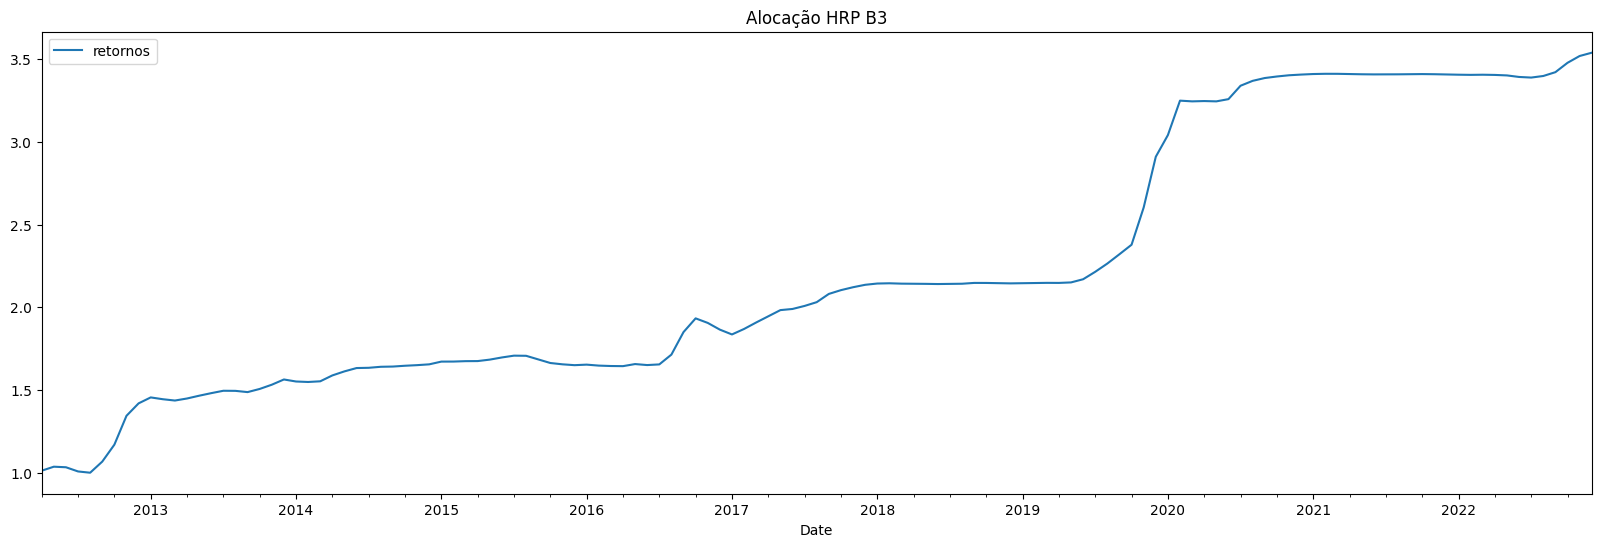

In [44]:
data=stock_prices.index[periodos+oot-1:]
hrp_rets = pd.DataFrame({'retornos':retornos}, index=data);hrp_rets
hrp_rets_plot = (1+hrp_rets).cumprod();hrp_rets_plot*100
hrp_rets_plot.plot(figsize=(20,6), title="Alocação HRP B3");
f.summary_stats(hrp_rets, .09)

,Annualized Return,Annualized Vol,Sharpe Ratio,Average Drawdown,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Max Drawdown
rets,0.139653,0.257319,0.177388,-0.076662,0.487673,7.084712,0.091424,0.134002,-0.46303


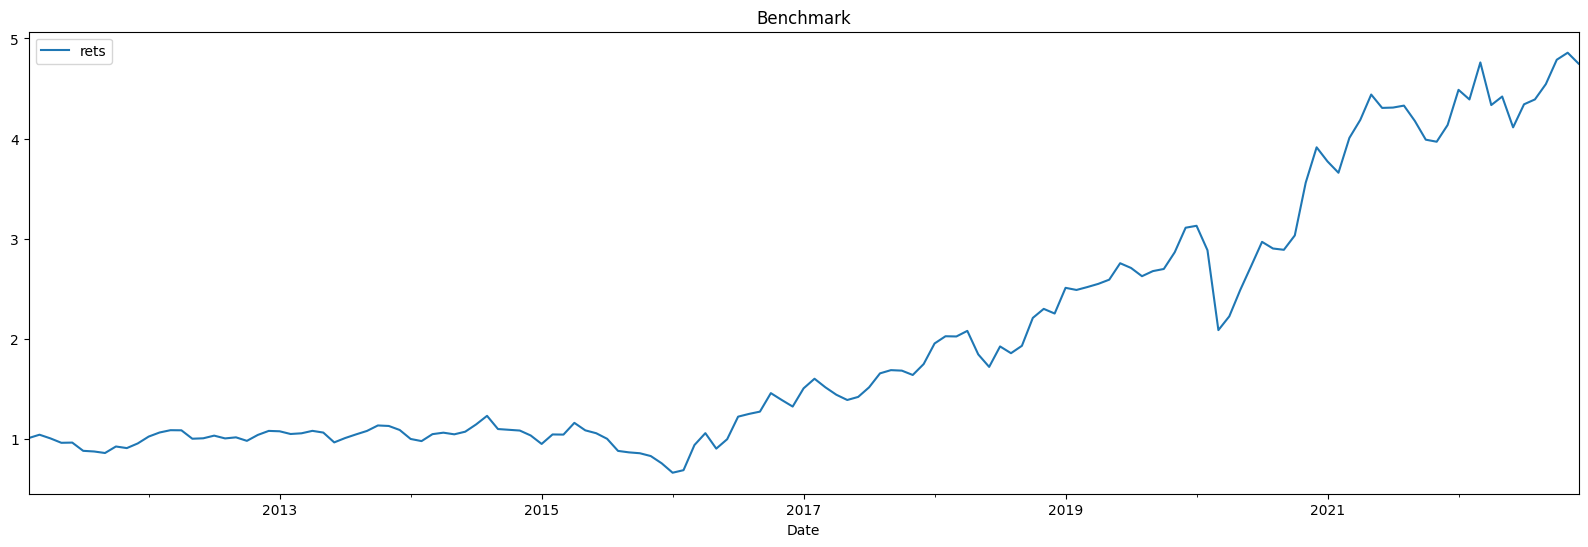

In [45]:
bm_rets = pd.DataFrame({'rets':f.backtest_ws(rets, 12)}).dropna(axis='rows')
bm = (1+bm_rets).cumprod()
bm.plot(figsize=(20,6), title="Benchmark");
f.summary_stats(pd.DataFrame(bm_rets['rets']), .09)


In [46]:
hrp_rets['2020':'2020'].T*100, bm_rets['2020':'2020'].T*100

(Date      2020-01-01  2020-02-01  2020-03-01  2020-04-01  2020-05-01  \
 retornos    4.506486    6.847258   -0.132946    0.057591   -0.058196   
 
 Date      2020-06-01  2020-07-01  2020-08-01  2020-09-01  2020-10-01  \
 retornos     0.41433     2.48763    0.886555    0.504627    0.274815   
 
 Date      2020-11-01  2020-12-01  
 retornos    0.217155    0.123975  ,
 Date  2020-01-01  2020-02-01  2020-03-01  2020-04-01  2020-05-01  2020-06-01  \
 rets    0.617915   -7.808265  -27.695717    6.611018   11.828199    9.620385   
 
 Date  2020-07-01  2020-08-01  2020-09-01  2020-10-01  2020-11-01  2020-12-01  
 rets    8.894196   -2.238392   -0.445889    4.972184    17.40012    9.930265  )

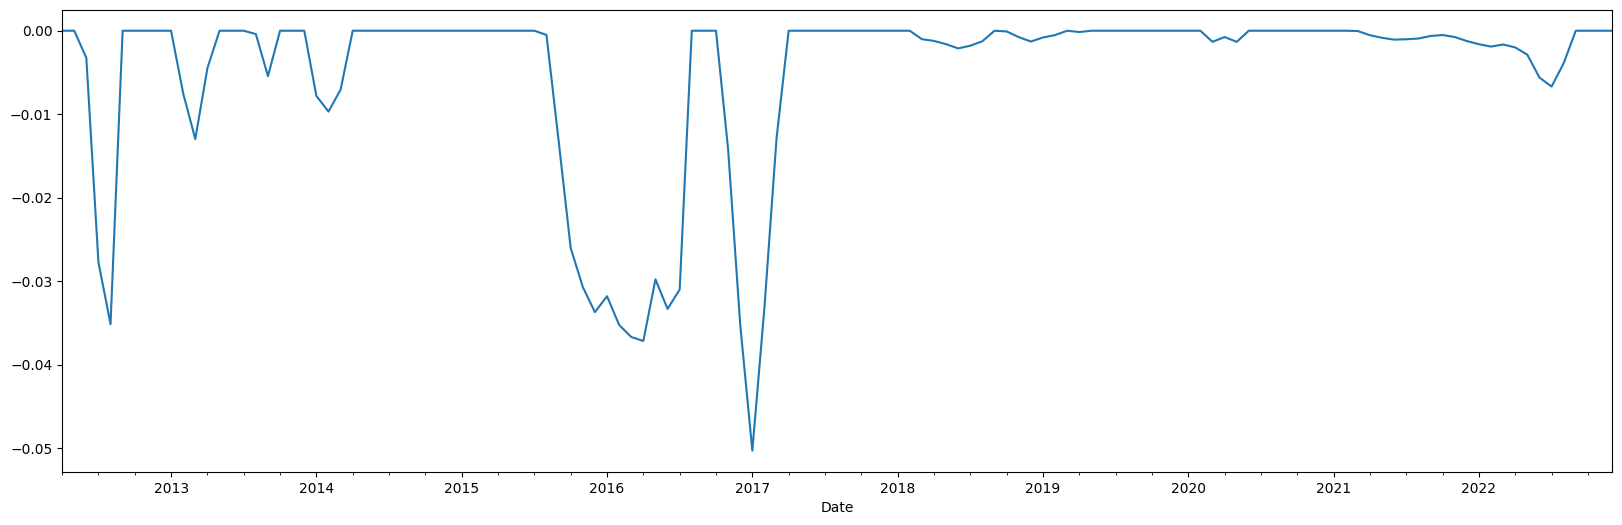

In [47]:
f.underwater_plot(hrp_rets['retornos'], figsize=(20,6))

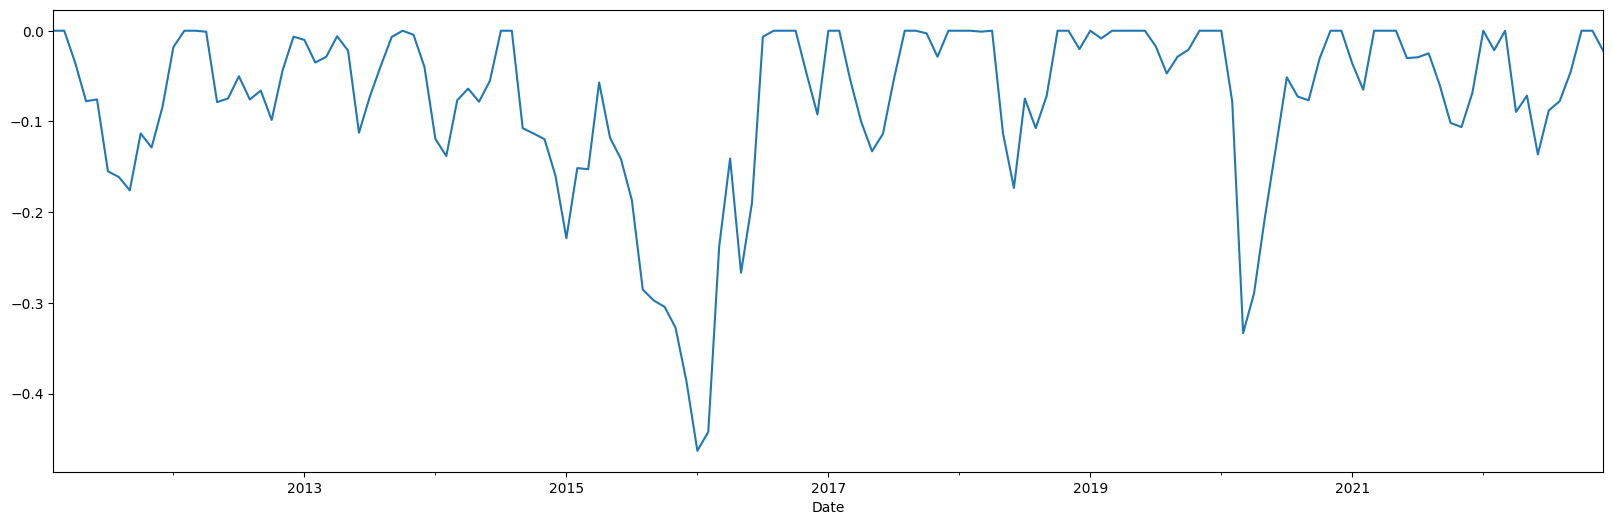

In [48]:
f.underwater_plot(bm_rets['rets'], figsize=(20,6))

c:\Users\pedro\Documents\ml-asset-allocation\functions.py:713: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(r, hist=True, bins=int(len(r)/2), color='b', label='Strategy')


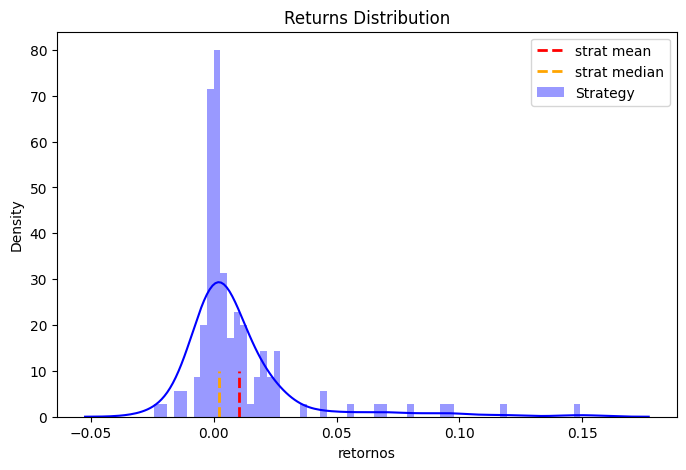

In [49]:
f.plot_rets_distribuition(hrp_rets['retornos'], figsize=(8,5));